In [4]:
import numpy as np
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from scripts.image_utils import reorder_tensor_dimensions, tensor_to_pil, display_images

In [3]:
repo = "shreyasgite/so100_base_env"
data = LeRobotDataset(repo, episodes = [1])

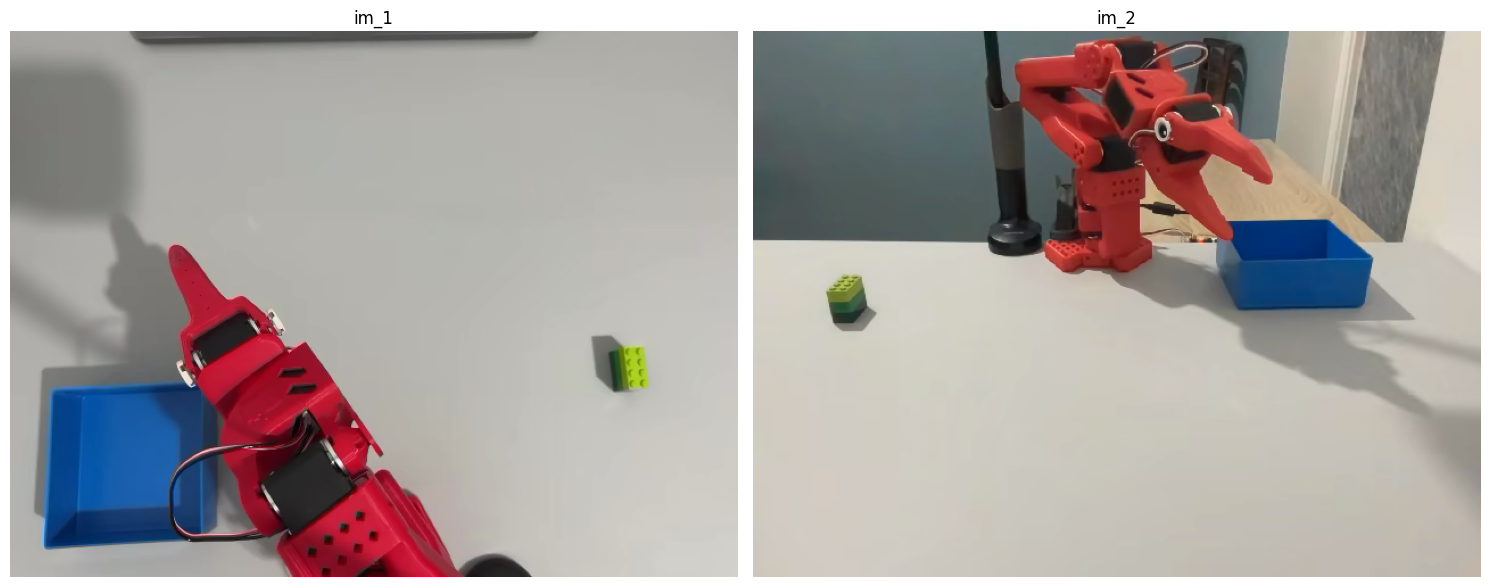

language_instruction:  Grasp a lego block and put it in the bin.
Robot state, that joint angles for the motors:  tensor([-32.0801, 166.0254, 162.1582,  40.2539,   6.0645,  31.1373])
Robot action:  tensor([  1.7578, 188.4375, 177.3633,  54.7559,  -7.5586,   0.0000])


In [ ]:
frame1 = data[0]
im_t_1 = frame1['observation.images.phone']
im_t_2 = frame1['observation.images.laptop']
l_1 = frame1['task']
q_1 = frame1['observation.state']
a_1 = frame1['action']

O_1 = [im_t_1, im_t_2, l_1, q_1]
im_1 = tensor_to_pil(reorder_tensor_dimensions(im_t_1))
im_2 = tensor_to_pil(reorder_tensor_dimensions(im_t_2))
display_images(im_1, im_2)
print("language_instruction: ", l_1)
print("Robot state, that joint angles for the motors: ", q_1)
print("Robot action: ", a_1)

In [17]:

H = 50
A_t = []
for i in range(H):
    a_t = data[i]['action']
    A_t.append(a_t)
A_t = np.array(A_t)

print(A_t[0])
print(A_t.shape)

[  1.7578125 188.4375    177.36328    54.75586    -7.5585938   0.       ]
(50, 6)


In [19]:

# Action dimension for your 6-motor so100 robot arm
ACTION_DIM = 6
# Horizon H: Number of future action steps in a chunk (as used in pi0 paper)
H = 50
# Number of integration steps for inference (as used in pi0 paper)
NUM_INTEGRATION_STEPS = 10
# Integration step size delta
DELTA = 1.0 / NUM_INTEGRATION_STEPS
# Parameters for sampling tau during training (from pi0 Appendix B)
# Shifted Beta(1.5, 1.0) distribution
BETA_A = 1.5
BETA_B = 1.0
# Cutoff for tau sampling (from pi0 Appendix B)
TAU_CUTOFF_S = 0.999

# --- Placeholder Model Function ---
# This function simulates the output of the trained Action Expert model (v_theta).
# In reality, this would be a neural network (transformer) taking observations
# and the current noisy action estimate as input.
def predict_vector_field_v_theta(noisy_actions_At_tau, timestep_tau, O_t):
    """
    Placeholder for the neural network model (Action Expert).
    Predicts the vector field pointing from noisy actions towards real actions.

    Args:
        noisy_actions_At_tau (np.array): The current noisy action chunk, shape (H, ACTION_DIM).
        timestep_tau (float): The current flow matching timestep (0 to 1).
        observation_context: Processed information from VLM (images, language, state).
                           (Not explicitly used in this placeholder).

    Returns:
        np.array: The predicted vector field, shape (H, ACTION_DIM).
    """
    print(f"    Model predicting vector field for tau={timestep_tau:.3f}")
    # In a real model, this involves complex computations (attention layers, etc.)
    # For this pseudo-code, let's return a dummy field (e.g., based on noise input)
    # This is JUST A PLACEHOLDER to make the code run.
    # A real model's output would depend on its learned weights.
    # Example: return simple direction towards zero
    return -noisy_actions_At_tau * 0.5 # Simple placeholder logic

# --- Training Process ---

def sample_flow_timestep_tau():
    """ Samples tau from the shifted Beta distribution used in the paper[cite: 429]. """
    # Sample from Beta(a, b)
    beta_sample = np.random.beta(BETA_A, BETA_B)
    # Shift and scale to be within [0, s]
    tau = TAU_CUTOFF_S * (1 - beta_sample)
    return tau

def create_noisy_actions_and_target(true_actions_At):
    """
    Creates the noisy action chunk At_tau and the target vector field u
    for a single training step[cite: 108].

    Args:
        true_actions_At (np.array): The ground truth action chunk from data,
                                   shape (H, ACTION_DIM).

    Returns:
        tuple: (noisy_actions_At_tau, target_vector_field_u, sampled_tau)
    """
    # 1. Sample timestep tau
    tau = sample_flow_timestep_tau()

    # 2. Sample noise epsilon ~ N(0, I)
    epsilon_noise = np.random.randn(H, ACTION_DIM)

    # 3. Compute noisy actions: At_tau = tau * At + (1 - tau) * epsilon
    noisy_actions_At_tau = tau * true_actions_At + (1.0 - tau) * epsilon_noise

    # 4. Compute target vector field: u = epsilon - At
    target_vector_field_u = epsilon_noise - true_actions_At

    return noisy_actions_At_tau, target_vector_field_u, tau

def calculate_training_loss(true_actions_At, observation_context):
    """
    Calculates the flow matching loss for one training example[cite: 106].

    Args:
        true_actions_At (np.array): The ground truth action chunk.
        observation_context: Context from the VLM based on robot observations (ot).

    Returns:
        float: The calculated loss value.
    """
    # 1. Generate noisy actions and the target vector field
    noisy_actions_At_tau, target_vector_field_u, sampled_tau = \
        create_noisy_actions_and_target(true_actions_At)

    # 2. Get the model's prediction for the vector field
    predicted_vector_field_v = predict_vector_field_v_theta(
        noisy_actions_At_tau,
        sampled_tau,
        observation_context
    )

    # 3. Calculate the loss (e.g., Mean Squared Error)
    # Loss = || v_theta(At_tau, ot) - u(At_tau | At) ||^2
    loss = np.mean((predicted_vector_field_v - target_vector_field_u)**2)

    return loss

# --- Inference Process (Action Generation) ---

def generate_actions_inference(observation_context):
    """
    Generates an action chunk using the trained model via iterative denoising[cite: 111].

    Args:
        observation_context: Context from the VLM based on robot observations (ot).

    Returns:
        np.array: The predicted action chunk At1, shape (H, ACTION_DIM).
    """
    print("\n--- Starting Inference ---")
    # 1. Start with pure random noise At0 ~ N(0, I)
    current_actions_At_tau = np.random.randn(H, ACTION_DIM)
    current_tau = 0.0
    print(f"Step 0: Initial noise generated, tau={current_tau:.3f}")

    # 2. Iteratively denoise using the Forward Euler integration rule
    for step in range(NUM_INTEGRATION_STEPS):
        # Get the predicted vector field from the model
        predicted_vector_field_v = predict_vector_field_v_theta(
            current_actions_At_tau,
            current_tau,
            observation_context
        )

        # Apply Euler step: At^{\tau+delta} = At^tau + delta * v_theta(At^tau, ot)
        current_actions_At_tau = current_actions_At_tau + DELTA * predicted_vector_field_v

        # Update tau for the next step
        current_tau += DELTA

        print(f"Step {step+1}/{NUM_INTEGRATION_STEPS}: Updated actions, tau={current_tau:.3f}")

    # 3. The result after N steps is the predicted action chunk At1
    predicted_actions_At = current_actions_At_tau
    print("--- Inference Complete ---")
    return predicted_actions_At


In [20]:
# --- Training Example ---
print("--- Calculating Training Loss Example ---")
loss_value = calculate_training_loss(A_t, O_1)
print(f"Calculated Training Loss: {loss_value:.6f}")
print("---------------------------------------")


# --- Inference Example ---
predicted_action_chunk = generate_actions_inference(O_1)
print(f"\nGenerated Action Chunk (Shape: {predicted_action_chunk.shape}):")
# print(predicted_action_chunk) # Optionally print the whole chunk
print(f"First action step in chunk: {predicted_action_chunk[0, :]}")
print(f"Last action step in chunk: {predicted_action_chunk[-1, :]}")
print("---------------------------------------")

--- Calculating Training Loss Example ---
    Model predicting vector field for tau=0.566
Calculated Training Loss: 6011.838653
---------------------------------------

--- Starting Inference ---
Step 0: Initial noise generated, tau=0.000
    Model predicting vector field for tau=0.000
Step 1/10: Updated actions, tau=0.100
    Model predicting vector field for tau=0.100
Step 2/10: Updated actions, tau=0.200
    Model predicting vector field for tau=0.200
Step 3/10: Updated actions, tau=0.300
    Model predicting vector field for tau=0.300
Step 4/10: Updated actions, tau=0.400
    Model predicting vector field for tau=0.400
Step 5/10: Updated actions, tau=0.500
    Model predicting vector field for tau=0.500
Step 6/10: Updated actions, tau=0.600
    Model predicting vector field for tau=0.600
Step 7/10: Updated actions, tau=0.700
    Model predicting vector field for tau=0.700
Step 8/10: Updated actions, tau=0.800
    Model predicting vector field for tau=0.800
Step 9/10: Updated action